## Genre Prediction of IMDB movies
The aim of this project to predict the genre of movies based on the description of a movie. The data for training and testing the model has been collected from IMDB website through web-scraping.

### Importing the required packages

In [2]:
# import the required packages
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

### Downloading required nltk data packages

In [3]:
# download required nltk data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/Bikiran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Bikiran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Bikiran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Bikiran/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Loading the dataset

In [4]:
# load the dataset from excel file.
xl = pd.ExcelFile('IMDB_StoryLine.xlsx')
raw_data_df = xl.parse('Sheet 1')

raw_data_df.head()

,link,title,year,runtime,genre,globalRate,text,votes,stars,creator,...,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,/title/tt0000417/?ref_=adv_li_tt,Die Reise zum Mond,1902,13.0,Short,8.2,A group of astronomers go on an expedition to ...,48021,"Georges Méliès, Victor André, Bleuette Bernon,...",Georges Méliès,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/title/tt0004052/?ref_=adv_li_tt,The Hazards of Helen,1914,NaN,Action,7.0,"Helen, informed of the danger which menaces an...",108,"Helen Holmes, Helen Gibson, J.P. McGowan, Ethe...","J. Gunnis Davis, J.P. McGowan, Robert G. Vignola",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,/title/tt0004465/?ref_=adv_li_tt,The Perils of Pauline,1914,199.0,Action,6.3,"Pauline, a young maiden, must protect herself ...",1026,"Pearl White, Crane Wilbur, Paul Panzer, Edward...","Louis J. Gasnier, Donald MacKenzie",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,/title/tt0006206/?ref_=adv_li_tt,Die Vampire,1915,421.0,Action,7.3,An intrepid reporter and his loyal friend batt...,4704,"Musidora, Édouard Mathé, Marcel Lévesque, Jean...",Louis Feuillade,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/title/tt0010323/?ref_=adv_li_tt,Das Cabinet des Dr. Caligari,1920,76.0,Horror,8.1,"Hypnotist Dr. Caligari uses a somnambulist, Ce...",61840,"Werner Krauss, Conrad Veidt, Friedrich Feher, ...",Robert Wiene,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Exploring and Cleaning the dataset

In [5]:
# check the columns in the dataframe
raw_data_df.columns

Index(['link', 'title', 'year', 'runtime', 'genre', 'globalRate', 'text',
       'votes', 'stars', 'creator', 'story_line', 'tag_line',
       'country_of_origin', 'language', 'color', 'sound_mix', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25'],
      dtype='object')

In [6]:
# select only 'genre', 'text, 'story_line' columns from the raw data
dataset_df = raw_data_df[['genre', 'text', 'story_line']].copy()

dataset_df.head()

,genre,text,story_line
0,Short,A group of astronomers go on an expedition to ...,An association of astronomers has convened to ...
1,Action,"Helen, informed of the danger which menaces an...",NaN
2,Action,"Pauline, a young maiden, must protect herself ...",Young Pauline is left a lot of money when her ...
3,Action,An intrepid reporter and his loyal friend batt...,NaN
4,Horror,"Hypnotist Dr. Caligari uses a somnambulist, Ce...","Francis, a young man, recalls in his memory th..."


In [7]:
# look at the basic information about the dataframe
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25293 entries, 0 to 25292
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   genre       25293 non-null  object
 1   text        25293 non-null  object
 2   story_line  20094 non-null  object
dtypes: object(3)
memory usage: 592.9+ KB


In [8]:
# check count of null values
dataset_df.isna().sum()

genre            0
text             0
story_line    5199
dtype: int64

We have 5199 null values (`NaN`) in the `story_line` column.  
We will impute the `story_line` column in our dataset with the value available in `text` column.

Also, on visual inspection of the dataset, we observed instances where the text in `story_line` column contained only the contributers name preceded by an 'Em dash'. We will replace such text also with `NaN` and then impute its value from the `text` column.

In [10]:
# replace rows with only contributers name with `NaN`
dataset_df.replace(r'^[—].*', np.nan, regex=True, inplace=True)

dataset_df.isna().sum()

genre            0
text             0
story_line    7396
dtype: int64

In [11]:
# impute the missing values of `story_line` with values from `text` column in the dataset
dataset_df['story_line'] = dataset_df['story_line'].mask(dataset_df['story_line'].isna(), other=dataset_df['text'])

dataset_df.head()

,genre,text,story_line
0,Short,A group of astronomers go on an expedition to ...,An association of astronomers has convened to ...
1,Action,"Helen, informed of the danger which menaces an...","Helen, informed of the danger which menaces an..."
2,Action,"Pauline, a young maiden, must protect herself ...",Young Pauline is left a lot of money when her ...
3,Action,An intrepid reporter and his loyal friend batt...,An intrepid reporter and his loyal friend batt...
4,Horror,"Hypnotist Dr. Caligari uses a somnambulist, Ce...","Francis, a young man, recalls in his memory th..."


In [12]:
# check to ensure no null values 
dataset_df.isna().sum()

genre         0
text          0
story_line    0
dtype: int64

Now, we will drop the `text` column from our dataset.

In [13]:
# drop `text` column
dataset_df.drop(columns='text', inplace=True)

dataset_df.head()

,genre,story_line
0,Short,An association of astronomers has convened to ...
1,Action,"Helen, informed of the danger which menaces an..."
2,Action,Young Pauline is left a lot of money when her ...
3,Action,An intrepid reporter and his loyal friend batt...
4,Horror,"Francis, a young man, recalls in his memory th..."


Now, we look at the `genre` column of the dataset.

In [14]:
# check 'genre' column
print(dataset_df['genre'].unique())
print(f'Total count of genre: {len(dataset_df.genre.unique())}')

['Short' 'Action' 'Horror' 'Fantasy' 'Comedy' 'Crime' 'Documentary'
 'Drama' 'Adventure' 'Biography' 'Western' 'Romance' 'Music' 'Musical'
 'Mystery' 'Family' 'Animation' 'History' 'Sci' 'War' 'Thriller' 'Film'
 'News' 'Game' 'Reality' 'Talk' 'Sport' 'Adult']
Total count of genre: 28


We have 28 different types of `genre` in our dataset.

In [15]:
# convert datatype of `genre` column to category
dataset_df['genre'] = dataset_df['genre'].astype('category')

dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25293 entries, 0 to 25292
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   genre       25293 non-null  category
 1   story_line  25293 non-null  object  
dtypes: category(1), object(1)
memory usage: 223.7+ KB


In [16]:
dataset_df['genre'].value_counts()

Comedy         5990
Drama          5613
Action         3935
Crime          2210
Animation      1556
Adventure      1350
Horror         1345
Biography       855
Documentary     601
Western         375
Short           236
Thriller        189
Mystery         169
Family          152
Fantasy         146
Reality         123
Romance         114
Musical          78
Sci              78
Game             48
Music            37
Film             23
History          18
News             16
Talk             11
War              11
Sport            10
Adult             4
Name: genre, dtype: int64

Now, we look at the frequency distribution of the categories in `genre` column.

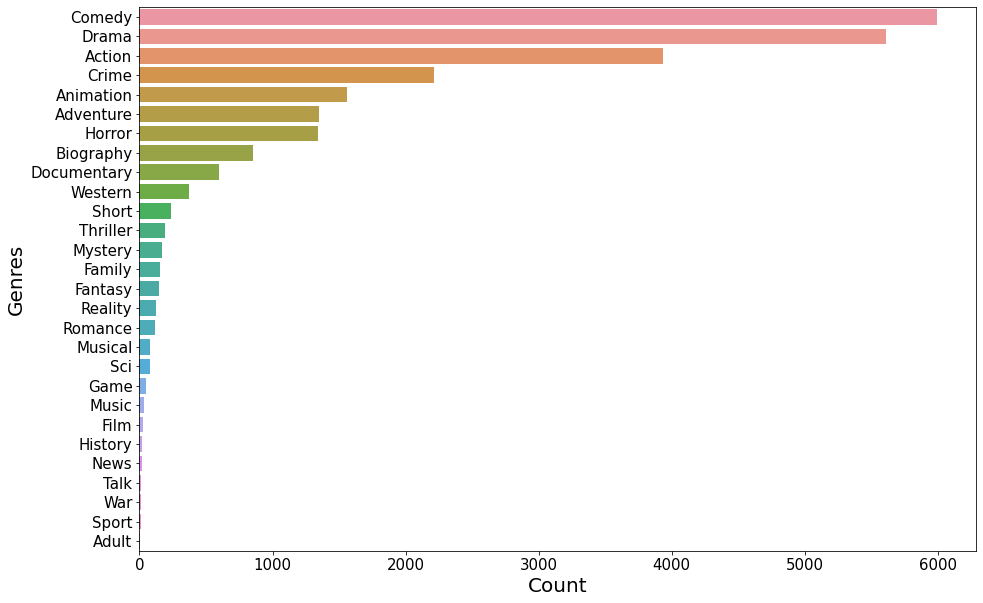

In [17]:
# plot a bar graph to visualise the frequency distribution
plt.figure(figsize=(15,10))

sns.countplot(y='genre', data=dataset_df, order=dataset_df['genre'].value_counts().index)

plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel(xlabel='Count', size=20)
plt.ylabel(ylabel='Genres', size=20)

plt.show()

### Data Pre-processing

Now, to carry out text analysis on the `story_line` column, we have to carry out certain pre-processing steps to transform the text data into a form which is understandable by the algorithms.

We carry out the following steps:
1. consider only alphabets and discard other types of characters in the text.
2. tokenisation of the paragraphs of text into words.
3. convert all the tokens into lower case words.
4. remove stopwords from the dataset.
5. lemmatisation of the words into their base words.

Below we carry out the above mentioned steps.

In [18]:
# using regex on the `story_line` column to consider only alphabets
dataset_df['story_line'] = dataset_df['story_line'].astype(str)
dataset_df['story_line'] = dataset_df['story_line'].map(lambda x: re.sub("[^a-zA-Z]"," ", x))

dataset_df['story_line'].head()

0    An association of astronomers has convened to ...
1    Helen  informed of the danger which menaces an...
2    Young Pauline is left a lot of money when her ...
3    An intrepid reporter and his loyal friend batt...
4    Francis  a young man  recalls in his memory th...
Name: story_line, dtype: object

In [19]:
# tokenise the paragraphs of `story_line` into words
dataset_df['story_tokens'] = dataset_df['story_line'].map(word_tokenize)

dataset_df['story_tokens'].head()

0    [An, association, of, astronomers, has, conven...
1    [Helen, informed, of, the, danger, which, mena...
2    [Young, Pauline, is, left, a, lot, of, money, ...
3    [An, intrepid, reporter, and, his, loyal, frie...
4    [Francis, a, young, man, recalls, in, his, mem...
Name: story_tokens, dtype: object

In [20]:
# transform all tokens to lower case
dataset_df['story_tokens'] = dataset_df['story_tokens'].map(lambda x: [w.lower() for w in x])

dataset_df['story_tokens'].head()

0    [an, association, of, astronomers, has, conven...
1    [helen, informed, of, the, danger, which, mena...
2    [young, pauline, is, left, a, lot, of, money, ...
3    [an, intrepid, reporter, and, his, loyal, frie...
4    [francis, a, young, man, recalls, in, his, mem...
Name: story_tokens, dtype: object

In [21]:
# remove stopwords
stop = set(stopwords.words('english'))

dataset_df['story_tokens'] = dataset_df['story_tokens'].map(lambda x: [w for w in x if w not in stop])

dataset_df['story_tokens'].head()

0    [association, astronomers, convened, listen, p...
1    [helen, informed, danger, menaces, excursion, ...
2    [young, pauline, left, lot, money, wealthy, un...
3    [intrepid, reporter, loyal, friend, battle, bi...
4    [francis, young, man, recalls, memory, horribl...
Name: story_tokens, dtype: object

In [22]:
# lemmatise the tokens
lemmatiser = WordNetLemmatizer()

dataset_df['story_tokens'] = dataset_df['story_tokens'].map(lambda x: [lemmatiser.lemmatize(w) for w in x])

dataset_df['story_tokens'].head()

0    [association, astronomer, convened, listen, pl...
1    [helen, informed, danger, menace, excursion, t...
2    [young, pauline, left, lot, money, wealthy, un...
3    [intrepid, reporter, loyal, friend, battle, bi...
4    [francis, young, man, recall, memory, horrible...
Name: story_tokens, dtype: object

Now, we drop the `story_line` column from the dataframe as we have extracted the desired tokens from the sentences in `story_tokens` column

In [23]:
# drop `story_line` column
dataset_df.drop(columns='story_line', inplace=True)

dataset_df.head()

,genre,story_tokens
0,Short,"[association, astronomer, convened, listen, pl..."
1,Action,"[helen, informed, danger, menace, excursion, t..."
2,Action,"[young, pauline, left, lot, money, wealthy, un..."
3,Action,"[intrepid, reporter, loyal, friend, battle, bi..."
4,Horror,"[francis, young, man, recall, memory, horrible..."


In [24]:
# convert numpy arrays back to single string for the `story_tokens` column
dataset_df['story_tokens'] = dataset_df['story_tokens'].map(lambda x: " ".join(x))

dataset_df.head()

,genre,story_tokens
0,Short,association astronomer convened listen plan pr...
1,Action,helen informed danger menace excursion train a...
2,Action,young pauline left lot money wealthy uncle dy ...
3,Action,intrepid reporter loyal friend battle bizarre ...
4,Horror,francis young man recall memory horrible exper...


### Label Encoding

We then encode the target variable to transform the categorical values into numerical values which the model can understand.

In [25]:
# encode the target labels
encoder = LabelEncoder()

dataset_df['genre_encode'] = encoder.fit_transform(dataset_df['genre'])

dataset_df.head()

,genre,story_tokens,genre_encode
0,Short,association astronomer convened listen plan pr...,22
1,Action,helen informed danger menace excursion train a...,0
2,Action,young pauline left lot money wealthy uncle dy ...,0
3,Action,intrepid reporter loyal friend battle bizarre ...,0
4,Horror,francis young man recall memory horrible exper...,14


In [26]:
encoded_genre = dataset_df[['genre', 'genre_encode']].drop_duplicates().\
                                            sort_values(by=['genre_encode']).\
                                            reset_index(drop=True)

encoded_genre

,genre,genre_encode
0,Action,0
1,Adult,1
2,Adventure,2
3,Animation,3
4,Biography,4
5,Comedy,5
6,Crime,6
7,Documentary,7
8,Drama,8
9,Family,9


### Splitting the dataset for training and testing

Now, we have our dataset ready to build a model to predict the genre based on the tokens extracted from the story line of the movies.

We begin by splitting the dataset into a training and testing dataset. 80% of the dataset will be used for training the model and 20% of the dataset will be unseen data for the model to test against it.

In [27]:
# split the dataset in a stratified manner
train_X, test_X, train_Y, test_Y = train_test_split(dataset_df['story_tokens'], dataset_df['genre_encode'],
                                                    test_size=0.2, random_state=143, stratify=dataset_df['genre_encode'])

In [28]:
# view the independent features of the training dataset
train_X.head()

14510    college girl janie inherits rundown strip club...
2628     holmes watson recruited serpentine fashion esc...
7194     bruno stroszek released prison warned stop dri...
4207     one vivid depiction horror nazi concentration ...
1553     pre civil war south plantation owner dy leaf p...
Name: story_tokens, dtype: object

In [29]:
# verify similar proportions of class distribution in training and testing dataset
print(Counter(train_Y))
print(Counter(test_Y))

Counter({5: 4792, 8: 4490, 0: 3148, 6: 1768, 3: 1245, 2: 1080, 14: 1076, 4: 684, 7: 481, 27: 300, 22: 189, 25: 151, 17: 135, 9: 122, 10: 117, 19: 98, 20: 91, 21: 62, 16: 62, 12: 38, 15: 30, 11: 18, 13: 15, 18: 13, 26: 9, 24: 9, 23: 8, 1: 3})
Counter({5: 1198, 8: 1123, 0: 787, 6: 442, 3: 311, 2: 270, 14: 269, 4: 171, 7: 120, 27: 75, 22: 47, 25: 38, 17: 34, 9: 30, 10: 29, 19: 25, 20: 23, 21: 16, 16: 16, 12: 10, 15: 7, 11: 5, 18: 3, 13: 3, 26: 2, 24: 2, 23: 2, 1: 1})


### Word Vectorisation

Now, we convert the text data into numerical features so that the algorithms can understand the different tokens.

There are different ways to vectorise our text data:
1. Bag of Words (BoW) using Count Vectorizer
2. Term Frequency - Inverse Document Frequency (TF-IDF)

We will use both the above methods to vectorise our training dataset and compare them later on.

##### Bag of Words using Count Vectorizer

In [30]:
# create a bag of words
bow_vectorizer = CountVectorizer()

# fit and transform the train_X dataset
train_X_bow = bow_vectorizer.fit_transform(train_X)

# transform the test_X dataset
test_X_bow = bow_vectorizer.transform(test_X)

##### Term Frequency-Inverse Document Frequency

In [31]:
# vectorise using tf-idf
tfidf_vectoriser = TfidfVectorizer()

# fit and transform the train_X dataset
train_X_tfidf= tfidf_vectoriser.fit_transform(train_X)

# transform the test_X dataset
test_X_tfidf = tfidf_vectoriser.transform(test_X)

### Using ML algorithms to build models to predict the genre

Now, we will use machine learning algorithms to predict the genre of the movies in the testing dataset.

There are different algorithms which we can use for this purpose.  
Here we will be using:
1. Multinomial Naive Bayes
2. Support Vector Machine (SVM)

##### Multinomial Naive Bayes

##### a. Bag of Words based word vectorisation

In [32]:
# fit the Naive Bayes classifier on the training data
nb_bow = MultinomialNB()
nb_bow.fit(train_X_bow, train_Y)

# predict the labels on the testing data
prediction_nb_bow = nb_bow.predict(test_X_bow)

In [33]:
# check F1 score of model
print(f"F1 score: {f1_score(test_Y, prediction_nb_bow, average='micro'):.2f}")

F1 score: 0.47


In [34]:
# check classification report of model
cr_nb_bow = classification_report(test_Y, prediction_nb_bow, target_names=list(encoded_genre['genre']), zero_division=0)

print(cr_nb_bow)

              precision    recall  f1-score   support

      Action       0.45      0.67      0.54       787
       Adult       0.00      0.00      0.00         1
   Adventure       0.51      0.08      0.14       270
   Animation       0.72      0.20      0.32       311
   Biography       0.64      0.04      0.08       171
      Comedy       0.49      0.74      0.59      1198
       Crime       0.51      0.30      0.38       442
 Documentary       0.62      0.07      0.12       120
       Drama       0.43      0.61      0.51      1123
      Family       0.00      0.00      0.00        30
     Fantasy       0.00      0.00      0.00        29
        Film       0.00      0.00      0.00         5
        Game       0.00      0.00      0.00        10
     History       0.00      0.00      0.00         3
      Horror       0.57      0.14      0.23       269
       Music       0.00      0.00      0.00         7
     Musical       0.00      0.00      0.00        16
     Mystery       0.00    

##### b. TF-IDF based word vectorisation

In [35]:
# fit the Naive Bayes classifier on the training data
nb_tfidf = MultinomialNB()
nb_tfidf.fit(train_X_tfidf, train_Y)

# predict the labels on the testing data
prediction_nb_tfidf = nb_tfidf.predict(test_X_tfidf)

In [36]:
# check F1 score of model
print(f"F1 score: {f1_score(test_Y, prediction_nb_tfidf, average='micro'):.2f}")

F1 score: 0.40


In [37]:
# check classification report of model
cr_nb_tfidf = classification_report(test_Y, prediction_nb_tfidf, target_names=list(encoded_genre['genre']), zero_division=0)

print(cr_nb_tfidf)

              precision    recall  f1-score   support

      Action       0.52      0.43      0.47       787
       Adult       0.00      0.00      0.00         1
   Adventure       0.00      0.00      0.00       270
   Animation       1.00      0.00      0.01       311
   Biography       0.00      0.00      0.00       171
      Comedy       0.39      0.84      0.54      1198
       Crime       0.83      0.01      0.02       442
 Documentary       0.00      0.00      0.00       120
       Drama       0.37      0.60      0.46      1123
      Family       0.00      0.00      0.00        30
     Fantasy       0.00      0.00      0.00        29
        Film       0.00      0.00      0.00         5
        Game       0.00      0.00      0.00        10
     History       0.00      0.00      0.00         3
      Horror       0.00      0.00      0.00       269
       Music       0.00      0.00      0.00         7
     Musical       0.00      0.00      0.00        16
     Mystery       0.00    

##### Support Vector Machine (SVM)

##### a. Bag of Words based word vectorisation

In [38]:
# fit the Support Vector Classifier on the training data
svm_bow = SVC()
svm_bow.fit(train_X_bow, train_Y)

# predict the labels on the testing data
prediction_svm_bow = svm_bow.predict(test_X_bow)

In [39]:
# check F1 score of model
print(f"F1 score: {f1_score(test_Y, prediction_svm_bow, average='micro'):.2f}")

F1 score: 0.45


In [40]:
# check performance of model
cr_svm_bow = classification_report(test_Y, prediction_svm_bow, target_names=list(encoded_genre['genre']), zero_division=0)

print(cr_svm_bow)

              precision    recall  f1-score   support

      Action       0.48      0.56      0.52       787
       Adult       0.00      0.00      0.00         1
   Adventure       0.47      0.03      0.06       270
   Animation       0.61      0.16      0.26       311
   Biography       0.50      0.01      0.02       171
      Comedy       0.44      0.72      0.54      1198
       Crime       0.50      0.32      0.39       442
 Documentary       0.86      0.21      0.34       120
       Drama       0.41      0.61      0.49      1123
      Family       0.00      0.00      0.00        30
     Fantasy       0.00      0.00      0.00        29
        Film       0.00      0.00      0.00         5
        Game       0.00      0.00      0.00        10
     History       0.00      0.00      0.00         3
      Horror       0.58      0.17      0.27       269
       Music       0.00      0.00      0.00         7
     Musical       0.00      0.00      0.00        16
     Mystery       0.00    

##### b. TF-IDF based word vectorisation

In [41]:
# fit the Support Vector classifier on the training data
svm_tfidf = SVC()
svm_tfidf.fit(train_X_tfidf, train_Y)

# predict the labels on the testing data
prediction_svm_tfidf = svm_tfidf.predict(test_X_tfidf)

In [42]:
# check F1 score of model
print(f"F1 score: {f1_score(test_Y, prediction_svm_tfidf, average='micro'):.2f}")

F1 score: 0.47


In [43]:
# check performance of model
cr_svm_tfidf = classification_report(test_Y, prediction_svm_tfidf, target_names=list(encoded_genre['genre']), zero_division=0)

print(cr_svm_tfidf)

              precision    recall  f1-score   support

      Action       0.48      0.61      0.54       787
       Adult       0.00      0.00      0.00         1
   Adventure       0.52      0.05      0.09       270
   Animation       0.73      0.23      0.35       311
   Biography       0.50      0.01      0.02       171
      Comedy       0.47      0.72      0.57      1198
       Crime       0.54      0.33      0.41       442
 Documentary       0.78      0.15      0.25       120
       Drama       0.43      0.64      0.51      1123
      Family       0.00      0.00      0.00        30
     Fantasy       0.00      0.00      0.00        29
        Film       0.00      0.00      0.00         5
        Game       0.00      0.00      0.00        10
     History       0.00      0.00      0.00         3
      Horror       0.57      0.15      0.24       269
       Music       0.00      0.00      0.00         7
     Musical       0.00      0.00      0.00        16
     Mystery       0.00    

### Confusion Matrix

We now plot the confusion matrix for the above models to analyse their performance

In [44]:
# function to transform confusion matrix to a dataframe
def confmat_to_df(predict_Y: np.ndarray) -> pd.DataFrame:
    
    # get the confusion matrix for predict_Y
    cm = confusion_matrix(test_Y, predict_Y)

    # define classnames for index and column names
    classnames = list(encoded_genre['genre'])

    # generate the dataframe
    df_cm = pd.DataFrame(cm, index=classnames, columns=classnames)

    return df_cm

In [45]:
# function to plot the confusion matrix using heatmap
def plot_confmat(predict_Y: np.ndarray):

    # get a dataframe form of the confusion matrix
    df_cm = confmat_to_df(predict_Y)
    
    plt.figure(figsize=(20,10))
    
    sns.heatmap(df_cm, linewidths=0.5, center=600, cmap='PuRd', linecolor='k')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')

    plt.show() 

    return None

##### Naive Bayes Classifier with Bag of Words

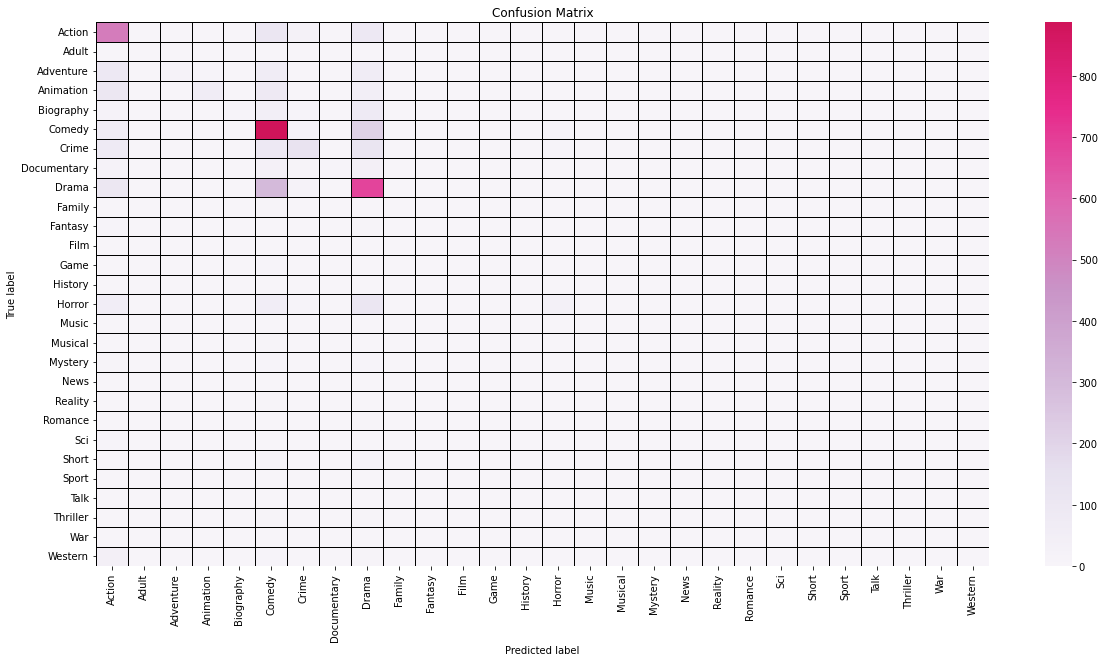

In [46]:
# heatmap of confusion matrix
plot_confmat(prediction_nb_bow)

##### Naive Bayes Classifier with TF-IDF

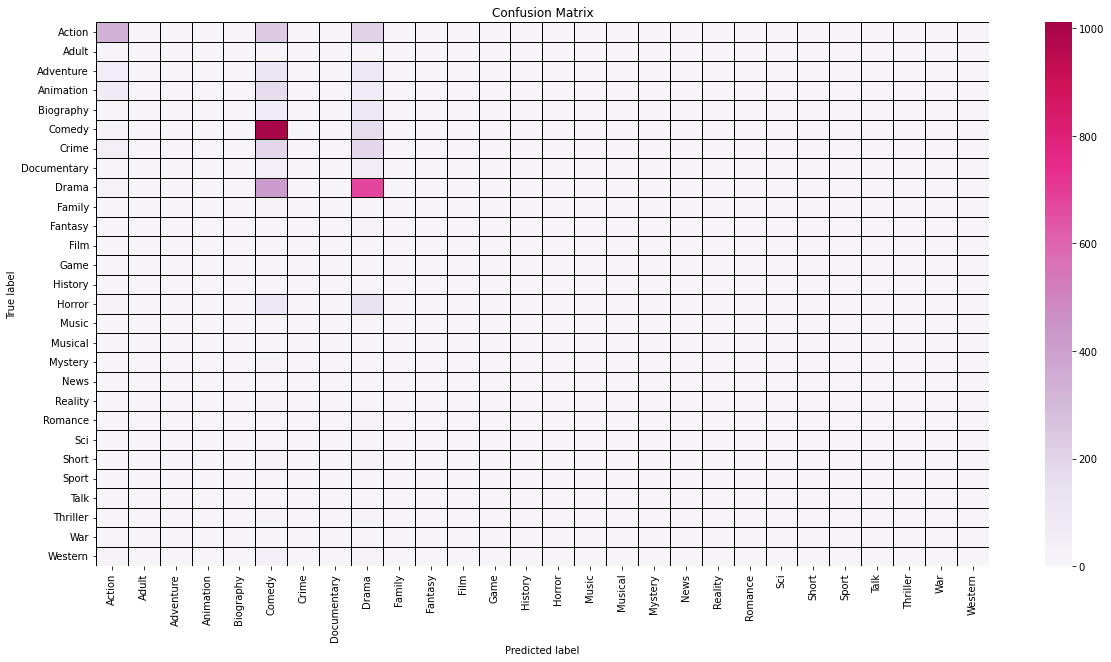

In [47]:
# heatmap of confusion matrix
plot_confmat(prediction_nb_tfidf)

##### SVM Classifier with Bag of Words

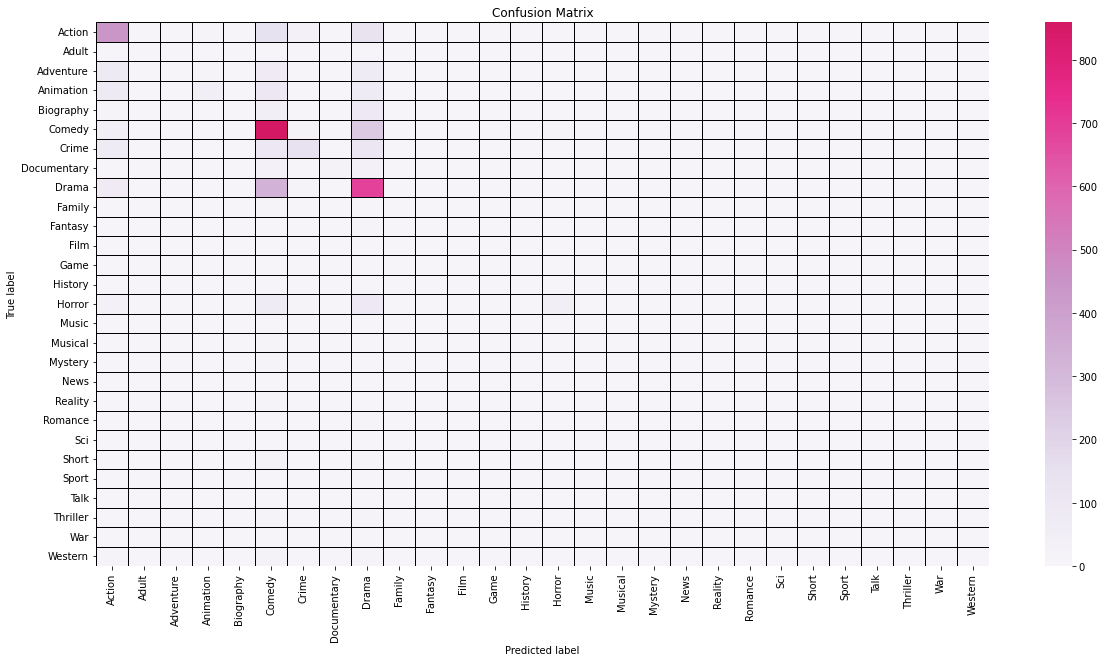

In [48]:
# heatmap of confusion matrix
plot_confmat(prediction_svm_bow)

##### SVM Classifier with TF-IDF

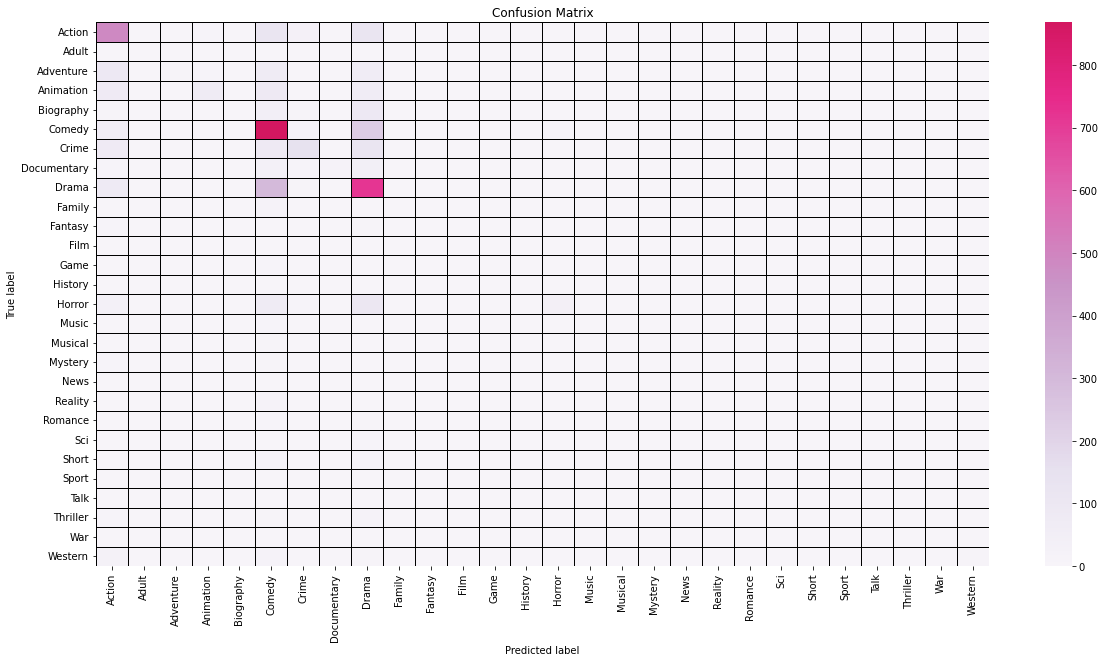

In [49]:
# heatmap of confusion matrix
plot_confmat(prediction_svm_tfidf)